In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.lab import Particles

from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4

def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

SMBH = Particles(1)
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

In [2]:
def relative_orbital_velocity(distance, mass=SMBH.mass):
    return (constants.G*mass/distance).sqrt()

def plot(body):
    scatter(body.x.value_in(units.pc), body.y.value_in(units.pc), s=20, alpha=0.5)
    #scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=80, c='r')
    pyplot.xlim(-r, r)
    pyplot.ylim(-r, r)
#     pyplot.colorbar()
#     pyplot.show()

def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

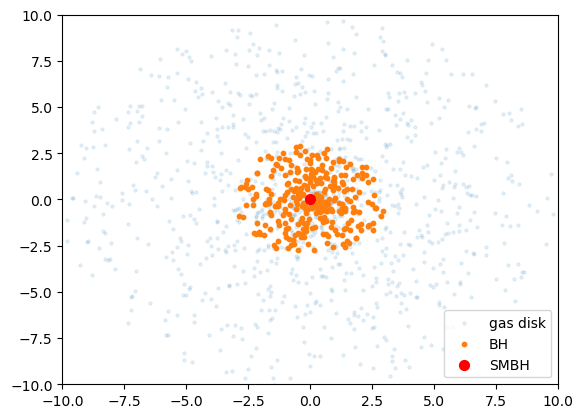

In [3]:
n_BHs = 300
alpha_IMF = -2.35
r=3

def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, 2.35)
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = "BH"
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
    BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.01
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
    gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)


scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
pyplot.xlim(-r, r)
pyplot.ylim(-r, r)
pyplot.legend(loc="best")
pyplot.show()

In [4]:
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Actually merger occurred:")
    print("Two BHs (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    new_particle=Particles(1)
    new_particle.mass = particles_in_encounter.total_mass()
    new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
    new_particle.position = com_pos
    new_particle.velocity = com_vel
    new_particle.radius = particles_in_encounter.radius.sum()
    bodies.add_particles(new_particle)
    bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)
            
def get_binaries(particles,hardness=10,G = constants.G):
    """
    returns the binaries in a particleset. binaries are selected according to a hardness criterion [hardness=10]
    This function returns the binaries as a list of i,j particles. Triple detection is not done.
    
    >>> from amuse import datamodel
    >>> m = [1,1,1] | units.MSun
    >>> x = [-1,1,0] | units.AU
    >>> y = [0,0,1000] | units.AU
    >>> z = [0,0,0] | units.AU
    >>> vx = [0,0,0] | units.kms
    >>> vy = [1.,-1.,0] | units.kms
    >>> vz = [0,0,0] | units.kms
    >>> particles = datamodel.create_particle_set( mass=m,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz )
    >>> binaries = particles.get_binaries()
    >>> print len(binaries)
    1
    
    """
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek

    a=numpy.argsort(particles.dist.number)
    a=np.delete(a,particles[a].name=="SMBH")

    binaries=[]

    for i in range(0, n-2):
        j=i+1
        while j<i+5 and j<n-1 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                binaries.append(binary)
            j+=1  

    return binaries

In [5]:
gravity = ph4(converter1, number_of_workers=32)
Nbody = BHdisk.copy()
Nbody.add_particles(SMBH)
Nbody.dist = dist(Nbody)
gravity.particles.add_particles(Nbody)
channel = gravity.particles.new_channel_to(Nbody)

In [ ]:
# dist(Nbody-SMBH).in_(units.pc) < (SMBH.radius.in_(units.pc)*1e5)

In [7]:
b1 = get_binaries(Nbody)

print(len(b1))

# print(b1[0])

# a=numpy.argsort(Nbody.dist.number)
# a=a[Nbody[a].name!="SMBH"]
# print(Nbody[a].name=="SMBH")

0


In [8]:
from amuse.community.huayno.interface import Huayno
from amuse.community.fi.interface import Fi

bodies = SMBH
bodies.add_particles(BHdisk)
bodies.add_particles(gasdisk)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name=="BH"]
gasdisk = bodies[bodies.name=="gas disk"]

Nbody = SMBH+BHdisk

gravityA = Huayno(converter2, workers=8)
gravityA.particles.add_particles(BHdisk)
channel = {"from BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter1, mode="openmp", workers=8)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 0.01*Pinner2 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 100 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

hydro.particles.add_particles(gasdisk)
hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

bodies.add_particles(gasdisk)

In [9]:
print(bodies.name)

['SMBH' 'BH' 'BH' ..., 'gas disk' 'gas disk' 'gas disk']


In [10]:
from amuse.couple import bridge
from amuse.ext.composition_methods import *
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

gravhydro.timestep = 0.2*Pinner2
print(0.2*Pinner2.in_(units.yr))

[290.667768024] 31556925.993600003 * s


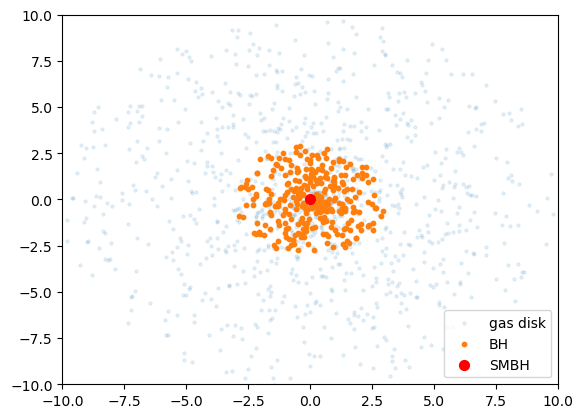

Evolved to t= [0.0145333884012] Myr , BH number= 300


In [ ]:
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
pyplot.xlim(-r, r)
pyplot.ylim(-r, r)
pyplot.legend(loc="best")
pyplot.show()

from amuse.ext.composition_methods import *
from amuse.ext.orbital_elements import orbital_elements_from_binary

def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies,
                         t_end):

    gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()
    model_time = 0 | units.Myr
    dt = 1.0*Pinner2
    x=1
    while model_time < t_end:

        model_time += dt

#         orbit_planet = orbital_elements_from_binary(bodies[:2], G=constants.G)
#         orbit_moon = orbital_elements_from_binary(bodies[1:3], G=constants.G)
#         print("Planet:", "ae=", orbit_planet[2].in_(units.AU), orbit_planet[3])
#         print("Moon:", "ae=", orbit_moon[2].in_(units.AU), orbit_moon[3])
        
#         dE_gravity = gravity_initial_total_energy/(gravity.get_total_energy()+hydro.get_total_energy())
#         print("Time:", model_time.in_(units.day), \
#               "dE=", dE_gravity)#, dE_hydro
        Nbody = SMBH+BHdisk
        if model_time.value_in(units.yr)>(x*Pinner2.value_in(units.yr)):
            x+=1
            print("Evolved to t=", model_time.in_(units.Myr),
                  ", BH number=", len(Nbody)-1)
           
        Nbody.collision_radius = Nbody.radius * collision_radius_multiplication_factor
        gravhydro.evolve_model(model_time)
        resolve_collision(stopping_condition, gravityA, Nbody)
        
        channel["to_BHs"].copy()
        channel["to_gasdisk"].copy()
        channel["to_smbh"].copy()
        
        scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
        scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
        scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
        pyplot.xlim(-r, r)
        pyplot.ylim(-r, r)
        pyplot.legend(loc="best")
        pyplot.show()
        
        Nbody.dist = dist(Nbody)
        b = get_binaries(Nbody)
        if(len(b)>0):
            print("Binary found:", b[0])
            break
        
#         print("S=", bodies[:3])
#         print("g=", gravity.particles)
#         print(gravity.particles.y.in_(units.pc), moon.y.in_(units.pc))

    gravityA.stop()
    hydro.stop()

t_end = 1000*Pinner2
gravity_hydro_bridge(gravityA, hydro, gravhydro, 
                     bodies, t_end)

# scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
# scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
# scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
# pyplot.xlim(-r, r)
# pyplot.ylim(-r, r)
# pyplot.legend(loc="best")
# pyplot.show()

In [ ]:
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.1, label="gas disk")
scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=1, label='BH')
scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=50, c='r', label='SMBH')
pyplot.xlim(-r, r)
pyplot.ylim(-r, r)
pyplot.legend(loc="best")
pyplot.show()